In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt
%matplotlib inline

let's try with gibbs denoising

In [2]:
tfd = tfp.distributions

In [278]:
class IsingGWGSampler(tf.keras.Model):
    
    def __init__(self, dim, A, b = 0., ising_temp=1.0):
        super(IsingGWGSampler, self).__init__()
        self.dim = dim
        self.A = A
        self.b = b
        self.ising_temp = ising_temp
#         assert tf.reduce_mean(tf.cast(tf.transpose(self.A) - A ==0, 'float32')) == 1., "\"A\" not symmetric"
        
    def sample(self, x, T = 10):
        # the sample function for multiple steps
        for t in range(T):
            x = self.take_step(x)
        
        return x
    
    def sample_with_logp(self, x, T = 10):
        # TODO: calculate log p  with samples
        logp_list = [self.logp(x).numpy(),]
        for t in range(T):
            x = self.take_step(x)
            logp_list.append(self.logp(x).numpy())
            
        return x, logp_list
        
    def take_step(self, x, ):
        dtilde_x = self.dtilde(x,)
        cat_x = tfd.Categorical(logits=tf.transpose(dtilde_x)/2)
        sampled_inds = cat_x.sample((1,))
        
        xp = self.flip(x, sampled_inds)
        dtilde_xp = self.dtilde(xp,)
        cat_xp = tfd.Categorical(logits=tf.transpose(dtilde_xp)/2)
        
        accept = self.metropolis_hastings_accept_step(xp, x, cat_xp, cat_x, sampled_inds)
        x_new = (1.- accept) * x + accept * xp
        
        return x_new
        
    def metropolis_hastings_accept_step(self, xp, x, cat_xp, cat_x, sampled_inds):    
        accept_prob = tf.minimum(tf.exp(self.logp(xp) - self.logp(x) \
                                 + cat_xp.log_prob(sampled_inds) - cat_x.log_prob(sampled_inds)), 1.)
        noise = tf.random.uniform(shape=tf.shape(sampled_inds))
        accepted_mask = tf.cast(noise < accept_prob, "float32")
        
        return accepted_mask
    
    @staticmethod    
    def flip(x, flips):
        flip_inds = tf.transpose(tf.concat([flips, tf.expand_dims(tf.range(tf.shape(flips)[1]),0)], axis=0))
        mask = tf.scatter_nd(indices = flip_inds, updates = tf.ones(flip_inds.shape[0]), shape=tf.shape(x))
        flipped_value = 1-tf.gather_nd(x, indices=flip_inds)
        scattered_update = tf.scatter_nd(indices=flip_inds, updates=flipped_value, shape=tf.shape(x))

        x_new = (1-mask) * x + mask * scattered_update

        return x_new
        
    def dlogpdx(self, x, ):
        x = 2.*x - 1
        if type(self.A) == tf.python.framework.sparse_tensor.SparseTensor:
            Ax = tf.sparse.sparse_dense_matmul(self.A, x)
        else:
            Ax = self.A@x
        return (2* self.ising_temp * Ax + self.b)
        
    def logp(self, x, ):
        x = 2.*x - 1
        if type(self.A) == tf.python.framework.sparse_tensor.SparseTensor:
            Ax = tf.sparse.sparse_dense_matmul(self.A, x)
        else:
            Ax = self.A@x
        btx = tf.reduce_sum(self.b*x, axis = 0, keepdims=True)
        xtAx = tf.reduce_sum(x*Ax, axis=0, keepdims=True)
        return (self.ising_temp/2 * xtAx + btx)
    
    def dtilde(self, x, ):
        return -(2*x-1) * self.dlogpdx(x)

In [272]:
class IsingGWGSampler_multihops(tf.keras.Model):
    
    def __init__(self, dim, A, b = 0., ising_temp=1.0, multihops=1):
        super(IsingGWGSampler_multihops, self).__init__()
        self.dim = dim
        self.A = A
        self.b = b
        self.multihops = multihops
        self.ising_temp = ising_temp
#         assert tf.reduce_mean(tf.cast(tf.transpose(self.A) - A ==0, 'float32')) == 1., "\"A\" not symmetric"
        
    def sample(self, x, T = 10):
        # the sample function for multiple steps
        for t in range(T):
            x = self.take_step(x)
        
        return x
    
    def sample_with_logp(self, x, T = 10):
        # TODO: calculate log p  with samples
        logp_list = [self.logp(x).numpy(),]
        for t in range(T):
            x = self.take_step(x)
            logp_list.append(self.logp(x).numpy())
            
        return x, logp_list
        
    def take_step(self, x, ):
        dtilde_x = self.dtilde(x,)
        cat_x = tfd.Categorical(logits=tf.transpose(dtilde_x)/2)
        sampled_inds = cat_x.sample((1,))
        
        xp = self.flip(x, sampled_inds)
        dtilde_xp = self.dtilde(xp,)
        cat_xp = tfd.Categorical(logits=tf.transpose(dtilde_xp)/2)
        
        accept = self.metropolis_hastings_accept_step(xp, x, cat_xp, cat_x, sampled_inds)
        x_new = (1.- accept) * x + accept * xp
        
        return x_new
        
    def metropolis_hastings_accept_step(self, xp, x, cat_xp, cat_x, sampled_inds):    
        accept_prob = tf.minimum(tf.exp(self.logp(xp) - self.logp(x) \
                                 + cat_xp.log_prob(sampled_inds) - cat_x.log_prob(sampled_inds)), 1.)
        noise = tf.random.uniform(shape=tf.shape(sampled_inds))
        accepted_mask = tf.cast(noise < accept_prob, "float32")
        
        return accepted_mask
    
    @staticmethod    
    def flip(x, flips):
        flip_inds = tf.transpose(tf.concat([flips, tf.expand_dims(tf.range(tf.shape(flips)[1]),0)], axis=0))
        mask = tf.scatter_nd(indices = flip_inds, updates = tf.ones(flip_inds.shape[0]), shape=tf.shape(x))
        flipped_value = 1-tf.gather_nd(x, indices=flip_inds)
        scattered_update = tf.scatter_nd(indices=flip_inds, updates=flipped_value, shape=tf.shape(x))

        x_new = (1-mask) * x + mask * scattered_update

        return x_new
    
    @staticmethod
    def flip_multi(x, flips):
        mask = tf.cast(flips, 'float32')
        tbf = mask * tf.transpose(x)[None, :, :]
        x_new = (1.-mask) * tf.transpose(x)[None, :, :] + mask * (1-tbf)

        return tf.transpose(x_new, [2, 1, 0])
        
    @staticmethod
    def ranked_matrix_multiplication(A, X):
        N = tf.shape(X)[0]
        X_reshaped = tf.reshape(X, (N, -1))

        if type(A) == tf.python.framework.sparse_tensor.SparseTensor:
            Ax = tf.sparse.sparse_dense_matmul(A, X_reshaped)
        else:
            Ax = A@X_reshaped

        return tf.reshape(Ax, tf.shape(X))
    
    def dlogpdx(self, x, ):
        x = 2.*x - 1
        Ax = ranked_matrix_multiplication(self.A, x)
        return 2 * self.ising_temp * Ax + self.b
        
    def logp(self, x, ):
        x = 2.*x -1
        Ax = ranked_matrix_multiplication(self.A, x)
        btx = tf.reduce_sum(self.b*x, axis = 0, keepdims=True)
        xtAx = tf.reduce_sum(x*Ax, axis=0, keepdims=True)
        return self.ising_temp/2 * xtAx + btx
    
    def dtilde(self, x, ):
        return -(2*x-1) * self.dlogpdx(x)

In [119]:
def flip(x, flips):
    flip_inds = tf.transpose(tf.concat([flips, tf.expand_dims(tf.range(tf.shape(flips)[1]),0)], axis=0))
    mask = tf.scatter_nd(indices = flip_inds, updates = tf.ones(flip_inds.shape[0]), shape=tf.shape(x))
    flipped_value = 1-tf.gather_nd(x, indices=flip_inds)
    scattered_update = tf.scatter_nd(indices=flip_inds, updates=flipped_value, shape=tf.shape(x))

    x_new = (1-mask) * x + mask * scattered_update

    return x_new

In [120]:
def flip_multi(x, flips):
    mask = tf.cast(flips, 'float32')
    tbf = mask * tf.transpose(x)[None, :, :]
    x_new = (1.-mask) * tf.transpose(x)[None, :, :] + mask * (1-tbf)
    
    return tf.transpose(x_new, [2, 1, 0])

In [121]:
def ranked_matrix_multiplication(A, X):
    N = tf.shape(X)[0]
    X_reshaped = tf.reshape(X, (N, -1))
    
    if type(A) == tf.python.framework.sparse_tensor.SparseTensor:
        Ax = tf.sparse.sparse_dense_matmul(A, X_reshaped)
    else:
        Ax = A@X_reshaped
    
    return tf.reshape(Ax, tf.shape(X))

In [187]:
test = IsingGWGSampler_multihops(10, tf.ones((10, 10), "float32"))

dtilde_x = test.dtilde(x,)
cat_x = tfd.OneHotCategorical(logits=tf.transpose(dtilde_x)/2)
sampled_inds = cat_x.sample((2,))

xp = flip_multi(x, sampled_inds)
dtilde_xp = test.dtilde(xp,)
cat_xp = tfd.OneHotCategorical(logits=tf.transpose(dtilde_xp)/2)

In [202]:
noise = tf.random.uniform(shape=tf.shape(sampled_inds[:, :, :1]))

In [210]:
accept_prob = tf.exp(test.logp(xp) - test.logp(x)[:, :,None] \
                   + tf.transpose(cat_xp.log_prob(sampled_inds) - cat_x.log_prob(sampled_inds))[None, :,:])
noise = tf.random.uniform(shape=tf.shape(accept_prob))

In [85]:
multi_flips = tfd.OneHotCategorical(logits = tf.transpose(tf.zeros((10, 3)))).sample((2, ))

In [97]:
flip_multi(tf.zeros((10, 3), 'float32'), multi_flips)[:, :, 0]# , [2,1,0]) + tf.expand_dims(tf.zeros((10, 3)), -1))[:, :, 0]

<tf.Tensor: shape=(10, 3), dtype=float32, numpy=
array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 1.],
       [0., 0., 0.],
       [0., 1., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [1., 0., 0.]], dtype=float32)>

In [249]:
import networkx as nx

In [250]:
G = nx.grid_2d_graph(100,100)

In [251]:
def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.SparseTensor(indices, coo.data, coo.shape)

In [287]:
B=nx.adjacency_matrix(G)
sparse_A = convert_sparse_matrix_to_sparse_tensor(B.astype('float32'))

In [307]:
test = IsingGWGSampler(B.shape[0], sparse_A)
x_new, logp = test.sample_with_logp(tf.cast(tf.random.uniform((10000,10)) > 0.5, "float32"), T=10000)

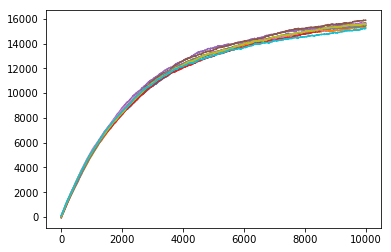

In [308]:
plt.plot(np.array(logp)[:, 0, :])
plt.show()

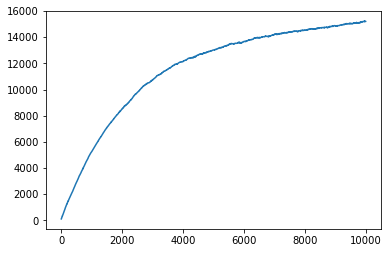

In [309]:
plt.plot(np.array(logp)[:, 0, -1])
plt.show()

the sample seems good, as good as any textbook sample of ising model

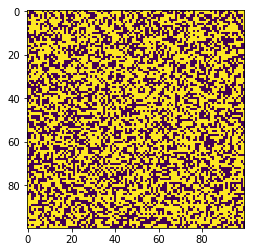

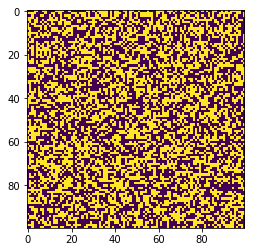

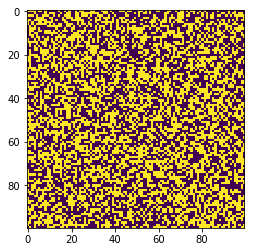

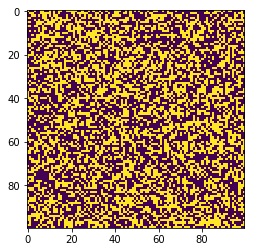

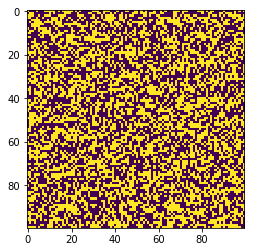

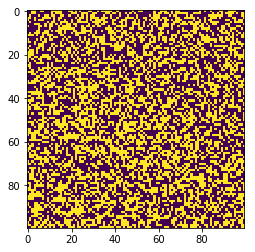

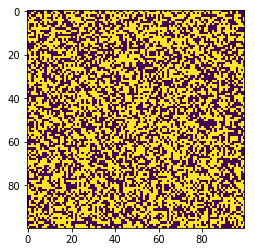

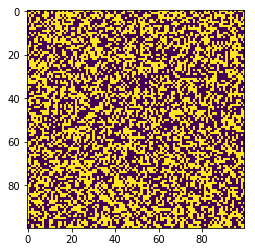

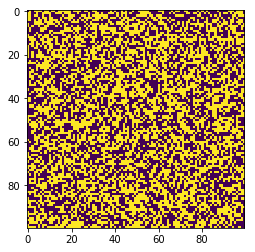

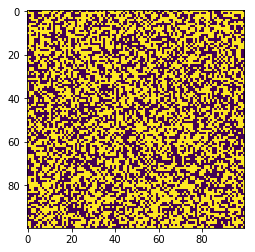

In [310]:
for i in range(10):
    plt.imshow(x_new[:, i].numpy().reshape((100, 100)))
    plt.show()

let's see more about the claim about circular graph

In [321]:
G = nx.circulant_graph(1000, [2])

In [322]:
B=nx.adjacency_matrix(G)
sparse_A = convert_sparse_matrix_to_sparse_tensor(B.astype('float32'))

In [323]:
test = IsingGWGSampler(B.shape[0], sparse_A)
x_new, logp = test.sample_with_logp(tf.cast(tf.random.uniform((1000,10)) > 0.5, "float32"), T=10000)

since the sampling method is more concerned with the "boundary points", ie the one that are most likely to be changed, it converge way faster for the circulant graph 

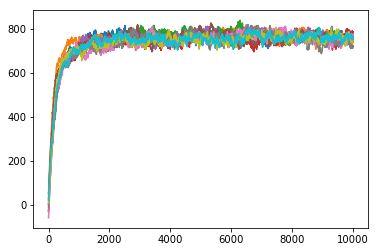

In [324]:
plt.plot(np.array(logp)[:, 0, :])
plt.show()

### Stochastic Block Model

In [1000]:
# heterogeneous degree graph
sizes = [75, 75, 300]
probs = [[0.25, 0.05, 0.02], [0.05, 0.35, 0.07], [0.02, 0.07, 0.40]]
G = nx.stochastic_block_model(sizes, probs, seed=0)

In [985]:
# homogeneous degree graph
sizes = [300, 300]
probs = [[0.25, 0.05, ], [0.05, 0.25,], ]
G = nx.stochastic_block_model(sizes, probs, seed=0)

In [1001]:
B=nx.adjacency_matrix(G)
sparse_A = convert_sparse_matrix_to_sparse_tensor(B.astype('float32'))

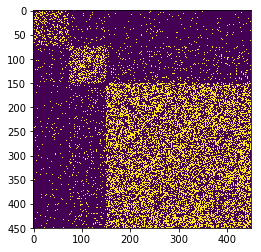

In [1002]:
plt.imshow(B.todense())
plt.show()

then we can write out the Gibbs sampling procedure, as the underlying graphical model is simply 

$$ z_i \rightarrow A_{ij} \leftarrow z_j$$

In [498]:
def take_upper_triangular_wo_diagonal(A):

    ones = tf.ones_like(A)
    mask_a = tf.linalg.band_part(ones, 0, -1) # Upper triangular matrix of 0s and 1s
    mask_b = tf.linalg.band_part(ones, 0, 0)  # Diagonal matrix of 0s and 1s
    mask = tf.cast(mask_a - mask_b, dtype=tf.bool) # Make a bool mask

    upper_triangular_flat = tf.boolean_mask(A, mask)
    
    return upper_triangular_flat

In [707]:
def log_joint_probability_onehot(Z, C, A):
    """
    @Z: matrix of shape (N, C)
    @C: matrix of shape (C, C)
    @A: matrix of shape (N, N), observed adj matrix
    """
    ZC = Z@C
    A_probs = ZC@tf.transpose(Z)
    
    A_tri = take_upper_triangular_wo_diagonal(tf.cast(A, "float32"))
    A_p_tri = take_upper_triangular_wo_diagonal(A_probs)

    return A_tri * tf.math.log(A_p_tri) + (1.-A_tri) * tf.math.log(1.-A_p_tri)

def pop_element_i(tensor, i):
    return tf.concat([tensor[:i], tensor[i+1:]], axis=0)

def flip_one_z(Z, C, A, i):
    """
    @Z: matrix of shape (N, C)
    @C: matrix of shape (C, C)
    @A: matrix of shape (N, N), observed adj matrix
    @i: which node to flip
    """
    # get the probability
    class_logits = []
    K = tf.shape(Z)[1]
    A_i = A[i, :][None, :]
    A_i = pop_element_i(A_i, i)
    
    for k in range(K):
        zk = tf.one_hot(k, K)[None, :]
        A_p_k = (zk@C)@tf.transpose(Z)
        A_p_k = pop_element_i(A_p_k, i)
        
        pos_logp = tf.reduce_sum(tf.math.log(A_p_k) * A_i) # include self node
        neg_logp = tf.reduce_sum(tf.math.log(1-A_p_k)*(1-A_i)) # don't include self node
        
        A_logit_k = pos_logp + neg_logp
        class_logits.append(A_logit_k)
    
    raw_p = tf.concat(class_logits, axis=0)
    norm_p = tf.nn.softmax(class_logits)
    
    new_k = tfd.Categorical(probs=norm_p).sample()
    new_z = tf.scatter_nd(indices = [[i, new_k]], updates = [1., ], shape=tf.shape(Z))
    
    mask = tf.one_hot(i, tf.shape(Z)[0])[:, None]
    return new_z * mask + Z * (1-mask)

def bp_one_z(Z, C, A, i):
    """
    @Z: matrix of shape (N, C)
    @C: matrix of shape (C, C)
    @A: matrix of shape (N, N), observed adj matrix
    @i: which node to flip
    """
    # get the probability
    class_logits = []
    K = tf.shape(Z)[1]
    A_i = A[i, :][None, :]
    A_i = pop_element_i(A_i, i)
    
    for k in range(K):
        zk = tf.one_hot(k, K)[None, :]
        A_p_k = (zk@C)@tf.transpose(Z)
        A_p_k = pop_element_i(A_p_k, i)
        
        pos_logp = tf.reduce_sum(tf.math.log(A_p_k) * A_i) # include self node
        neg_logp = tf.reduce_sum(tf.math.log(1-A_p_k)*(1-A_i)) # don't include self node
        
        A_logit_k = pos_logp + neg_logp
        class_logits.append(A_logit_k)
    
    raw_p = tf.concat(class_logits, axis=0)
    new_k = tf.cast(tf.argmax(class_logits), 'int32')
    
    new_z = tf.scatter_nd(indices = [[i, new_k]], updates = [1., ], shape=tf.shape(Z))
    
    mask = tf.one_hot(i, tf.shape(Z)[0])[:, None]
    return new_z * mask + Z * (1-mask)

In [703]:
from tqdm import tqdm_notebook as tqdm

In [1032]:
tf_p = tf.constant(probs)
dense_A = tf.sparse.to_dense(sparse_A)

N = sum(sizes)
T = 50
Z = tf.cast(tfd.OneHotCategorical(logits=tf.ones((len(sizes),))).sample((N)), "float32")
logp_record = [log_joint_probability_onehot(Z, tf_p, dense_A).numpy(),]

for t in tqdm(range(T)):
    order = tf.random.shuffle(tf.range(N))
    
    for i in order:
        Z = flip_one_z(Z, tf_p, dense_A, i)
    logp_record.append(log_joint_probability_onehot(Z, tf_p, dense_A).numpy())
        


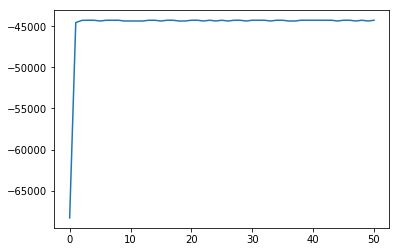

In [1033]:
plt.plot(np.array(logp_record).sum(axis=1))
plt.show()

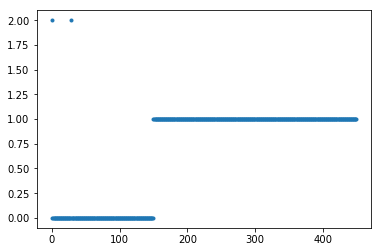

In [1034]:
plt.plot(tf.argmax(Z, axis=-1), '.')

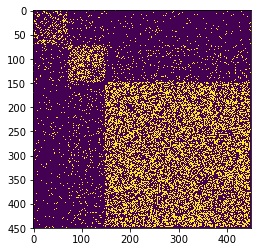

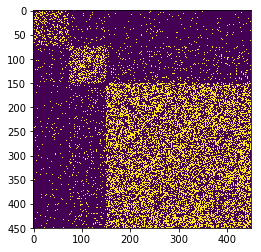

In [1035]:
plt.imshow(rearrange_by_membership(dense_A, Z))
plt.show()
plt.imshow(dense_A)

we are stuck in a local minima that might take forever to get out - as this is clearly not the global maximum, which is not THAT far off in terms of log joint likelihood, but (knowing the ground truth) very far off from the true assignment

In [716]:
true = np.concatenate([0*np.ones((75, )), 1*np.ones((75,)), 2*np.ones((300, ))], axis=0)
true_cat = tf.one_hot(true, 3)

In [717]:
log_joint_probability_onehot(true_cat, tf_p, dense_A).numpy().sum()

-42794.176

if we start from this true assignment we never leave

In [718]:
z_from_true = flip_one_z(true_cat, tf_p, dense_A, i)

In [719]:
(tf.argmax(z_from_true, axis=-1) != tf.argmax(true_cat, axis=-1)).numpy().mean()

0.0

#### Gibbs with Gradient

In [801]:
def calculate_dZ(Z, C, A):
    Z_param = tf.Variable(Z, trainable=True)

    with tf.GradientTape() as tape:
        ll = log_joint_probability_onehot(Z_param, C, A)

    dZ = tape.gradient(ll, Z_param)
    
    return dZ

def dtilde(Z, dZ):
    return dZ - tf.reduce_sum(Z*dZ, axis=-1, keepdims=True)

def calculate_qi_x(df):
    N, K = tf.shape(df)[0], tf.shape(df)[1]
    flatten_df = tf.reshape(df, (N*K, ))
    
    qi_x = tfd.OneHotCategorical(logits=flatten_df)
    
    return qi_x

def GWG_SBM_step(Z, C, A):
    dZ = calculate_dZ(Z, C, A)
    df = dtilde(Z, dZ) 
    qi_x = calculate_qi_x(df/2)
    
    new_Z = qi_x.sample()
    logprob_zp = qi_x.log_prob(new_Z)
    new_Z_stacked = tf.reshape(new_Z, tf.shape(Z))
    
    dZp = calculate_dZ(new_Z_stacked, C, A)
    dfp = dtilde(new_Z_stacked, dZ) - new_Z_stacked*1e8
    qi_xp = calculate_qi_x(dfp/2)
    
    logprob_z = qi_xp.log_prob(new_Z)
    
    logprob_ratio = log_joint_probability_onehot(new_Z_stacked) - log_joint_probability_onehot(Z) \
                    + logprob_zp - logprob_z
    
    accept = tf.random.uniform(()) < tf.minimum(1., tf.exp(logprob_ratio))

In [993]:
def sample_with_logprob_and_change(logits, Z,):
    # first pop out the unneccesary ones
    popped_logits = tf.boolean_mask(logits, 1-Z)
    # sample
    rv = tfd.OneHotCategorical(logits=popped_logits)
    sample = rv.sample() # this will be 1 dim
    logp = rv.log_prob(sample)
    
    # now we need to assemble together the result
    Z_new = tf.scatter_nd(indices=tf.cast(tf.where(1-Z), 'int32'), 
                          updates=sample,
                          shape=tf.shape(Z))
    
    return tf.cast(Z_new, 'float32'), logp, sample

def find_reverse_change(masked_Z, flatten_change):
    # find changed dimension
    changed_dim = tf.reduce_sum(tf.reshape(flatten_change, tf.shape(masked_Z)), 
                                axis=-1, keepdims=True)
    rev_Z = masked_Z * tf.cast(changed_dim, "float32")
    
    return tf.reshape(rev_Z, (-1, ))
    
def GWG_SBM_step(Z, C, A):
    dZ = calculate_dZ(Z, C, A)
    df = dtilde(Z, dZ) 
    
    flipped_one, logp_fw, flatten_change = sample_with_logprob_and_change(df/2, Z)
    
    flip_mask = tf.reduce_sum(flipped_one, axis=-1, keepdims=True)
    Zp = flipped_one * flip_mask + (1.-flip_mask)*Z
    
    dZp = calculate_dZ(Zp, C, A)
    dfp = dtilde(Zp, dZp)
    
    masked_Z = tf.boolean_mask(Z, 1-Zp)
    masked_logits = tf.boolean_mask(dfp/2, 1-Zp)
    logp_bw = tfd.OneHotCategorical(logits = masked_logits)\
                .log_prob(find_reverse_change(masked_Z, flatten_change))
        
    logprob_ratio = tf.reduce_sum(log_joint_probability_onehot(Zp, C, A)) \
                    - tf.reduce_sum(log_joint_probability_onehot(Z, C, A)) \
                    + logp_fw - logp_bw
    
    accept = tf.cast(tf.random.uniform(()) < tf.minimum(1., tf.exp(logprob_ratio)), 'float32')
    Z_new = accept * Zp + (1-accept) * Z
    
    return Z_new


In [1050]:
tf_p = tf.constant(probs)
dense_A = tf.sparse.to_dense(sparse_A)
N = dense_A.shape[0]

T = 1000
Z = tf.cast(tfd.OneHotCategorical(logits=tf.ones((len(sizes),))).sample((N)), "float32")
logp_list= [tf.reduce_sum(log_joint_probability_onehot(Z, tf_p, dense_A)).numpy(),]

for t in tqdm(range(T)):
    Z = GWG_SBM_step(Z, tf_p, dense_A, )
    logp_list.append(tf.reduce_sum(log_joint_probability_onehot(Z, tf_p, dense_A)).numpy())


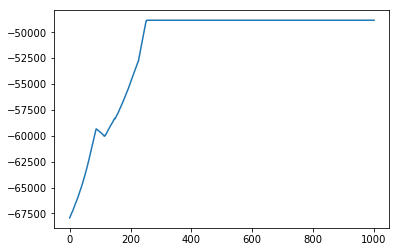

In [1051]:
plt.plot(logp_list)

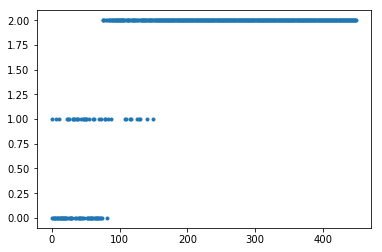

In [1052]:
plt.plot(tf.argmax(Z, axis=-1), '.')

In [1053]:
(tf.argmax(Z, axis=-1)==0).numpy().mean(), (tf.argmax(Z, axis=-1)==1).numpy().mean(), (tf.argmax(Z, axis=-1)==2).numpy().mean()

(0.11777777777777777, 0.08, 0.8022222222222222)

In [1054]:
75/450, 75/450, 300/450

(0.16666666666666666, 0.16666666666666666, 0.6666666666666666)

In [1055]:
def rearrange_by_membership(A, Z):
    N, K = tf.shape(Z)
    sorted_Z = []
    
    for k in range(K):
        sorted_Z.append(tf.range(N)[tf.argmax(Z, axis=-1)==k])
    sorted_Z = tf.concat(sorted_Z, axis=-1)
    
    return A.numpy()[sorted_Z.numpy(), :][:, sorted_Z.numpy()]

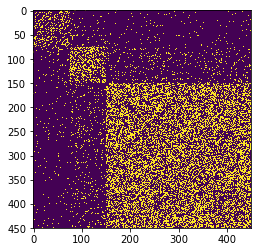

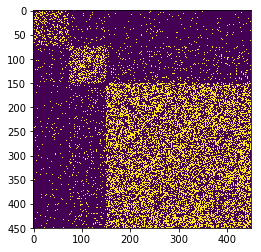

In [1056]:
plt.imshow(rearrange_by_membership(dense_A, Z))
plt.show()
plt.imshow(dense_A)

In [982]:
z_from_true = GWG_SBM_step(true_cat, tf_p, dense_A, )

In [983]:
tf.reduce_sum(log_joint_probability_onehot(z_from_true, tf_p, dense_A)).numpy()

-42794.094

In [984]:
tf.reduce_sum(log_joint_probability_onehot(true_cat, tf_p, dense_A)).numpy()

-42794.094